# Analysis of Number of CPUs on Memory

Note, to generate the serialized objects used in this analysis, you will need to navigate to this directory and run the following command:
```sh
sudo <path to julia> script.jl
```

Parameters of this setup:

* Small CNN on Cifar-10 dataset
* Batch size 128
* 2 epochs of training
* Sample Interval of 0.5
* CPU Sets used: 0, 0-1, 0-3, 0-5, 0-11 (all)

Note that the runs on 0 and 0-1 may be affected because processor 0 was being used by another process.

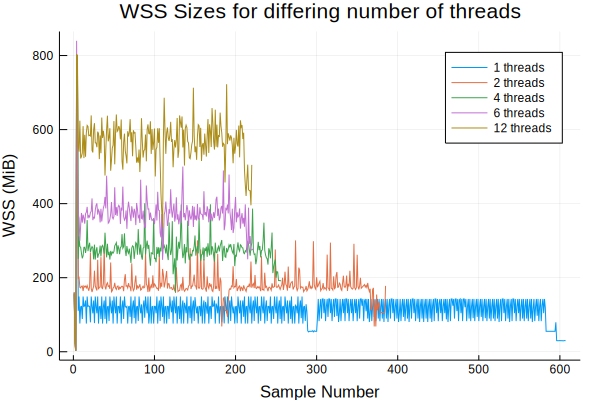

In [1]:
# Set up environment from Launcher
using Pkg
Pkg.activate("../../Launcher")
using Serialization, Statistics

using Launcher, MemSnoop, Plots

trackers = open(deserialize, "cnn_cpu_sweep.jls")

# Convenience Functions
size_mb(x) = 4 * x / 1024
make_cdf(x::MemSnoop.StackTracker) = MemSnoop.cdf(MemSnoop.transform(x.distances))
memory_vec(x) = size_mb.(1:length(x))

num_threads = ["1", "2", "4", "6", "12"]
plot()
for (tracker, nt) in zip(trackers, num_threads)
    plot!(size_mb.(tracker.active_pages), lab = "$nt threads")
end
title!("WSS Sizes for differing number of threads")
ylabel!("WSS (MiB)")
xlabel!("Sample Number")

Also note: The above image also gives us an idea of how the running time scales with the number of threads. Note that the speed up from 6 threads to 12 threads is ... not great, especially when considering the increase in memory needed.

length.(cdfs) = [304492, 388340, 531241, 585697, 667240]


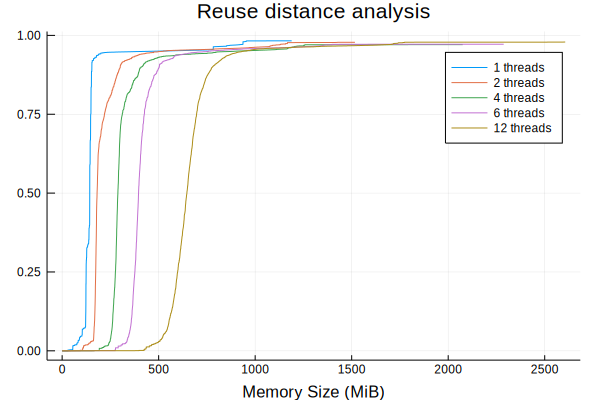

In [2]:
cdfs = make_cdf.(trackers)
memories = memory_vec.(cdfs)

# Plotting these directly kills my Jupyter. Too many dots?
subsample(x, n) = x[1:n:length(x)]
@show length.(cdfs)

cdfs_subsampled = subsample.(cdfs, 100)
memories_subsampled = subsample.(memories, 100)

plot()
for (m,c,nt) in zip(memories_subsampled, cdfs_subsampled, num_threads)
    plot!(m, c, lab = "$nt threads")
end
title!("Reuse distance analysis")
xlabel!("Memory Size (MiB)")

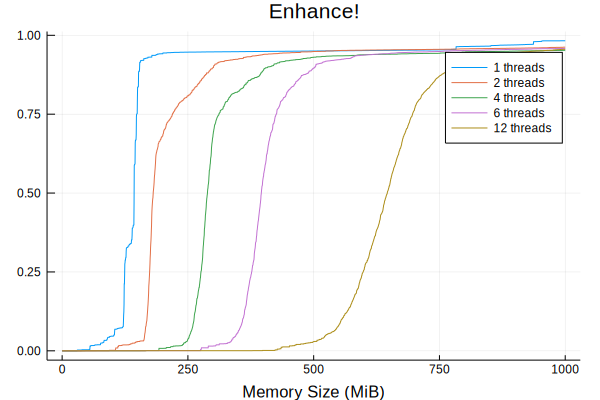

In [3]:
plot()
for (m,c,nt) in zip(memories_subsampled, cdfs_subsampled, num_threads)
    ind = findfirst(x -> x > 1000, m)
    plot!(m[1:ind], c[1:ind], lab = "$nt threads")
end
title!("Enhance!")
xlabel!("Memory Size (MiB)")

The jump from 6 threads to 12 threads really does not save us much ...